# Cycling Caloric Expenditure Models
---

The model through which caloric expenditure is calculated is a discrete system relying on a metric known as the metabolic equivalent for task (MET). The scale of METs has been optimized over the years through rigorous examinations. However, the MET units remain discrete integers and do not allow for continuous calculations to be performed. This limitation means that someone running at 6.0 miles per hour for an hour will otensibly burn the same number of calories as someone running 6.5 miles per hour for the same duration because the MET scale grants 10 MET units to any running activity between 6.0 and 6.7 miles per hour. See the table below.

<img src="jupyter-figures/met-table.jpg"/>

Consider a cyclist weighing 155 pounds and biking for 3 hours at 15.98 mph average. This cyclist will burn 3690.48 calories during their workout. However, the same cyclist riding for the same duration averaging 15.99 mph will burn 4428.57 calories. A third hypothetical cyclist of the same weight riding for the same duration at 16.00 mph will also burn 4428.57 calories according to the METs scale.

This system of discrete calorie consumption simply does not render accurate results. The discontinuities must be accounted for by creating a continuous calculation. By applying polynomial regression models against the MEPs discreete distribution, a more accurate model of caloric expenditure can be created.

In addition to the development of continuous MET for bicycling, a continuous power-based approach to caloric consumption is created based on the stationary bike MET units, trading watts for average speed. Power is an ideal approach to calculating caloric expenditure because it accounts for external factors such as grade and wind. In a speed-based approach, caloric consumption decreases with grade because speed decreases with grade just as with wind resistance. However, we know that increased grades and net-headwinds increase the overall energy consumption. Ergo, the speed-based approach is inherently inefficient under such circumstances. Power, on the other hand, is a direct measure of the athlete's performance and adjusts accordingly to grade and wind just as the athlete does. Despite the superiority of this approach, power is not immediately available in the field because power pedals are expensive. The groundwork for this model is provided but cannot be experimentally verified.

---

## <a name="TOC"></a> Table of Contents
1. [Discrete MET Calculation](#discrete-met)
2. [Continuous MET Calculation](#continuous-met)
3. [Power Based MET Calculation](#power-based-met)
4. [Experimental Observations](#experimental-observations)
    1. [Zeopoxa](#zeopoxa)
    2. [Under Armour](#under-armour)
    3. [Garmin](#garmin)
    4. [Comparisons](#comparisons)
5. [Conclusions](#conclusions)


In [1]:
# -------------------- CONFIGURE ENVIRONMENT -------------------- #

%reset -f

import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import json
import math

from pathlib import Path
path_figures = Path("figures")
path_data = Path("data")



## <a name="discrete-met"></a> [Discrete MET Calculations](#TOC)

Prior to developing the continuous MET (CMET) model, it is important to develop a baseline understanding of the current discrete MET (DMET) model and its flaws. The MET model provides a series of known points of metabolic equivalent outputs per given task (e.g. running, cycling, swimming, jumprope, etc.) based on the intensity through which the task is performed. For cycling, running and swimming the intensity is measured by the average speed throughout the workout. The MET value is then combined with the weight of the cyclist and duration of the task like so:

$$
\begin{equation}
    \text{caloric expenditure} = .0175 \cdot \text{METs} \cdot \text{weight} \; (\text{kg}) \cdot \text{duration} \; (\text{minutes})
\end{equation}
$$

This definition means that the confidence in the caloric expenditure is maximized at the points where DMET is defined and minimized where DMET is undefined. The model does not, however, provide any output for data points for which there has been no experimental verification. These deadzones present a serious issue for any athlete who does not perform at the exact points of the models certainty.

The following cells demonstrate these claims through visualizations of the DMET model.



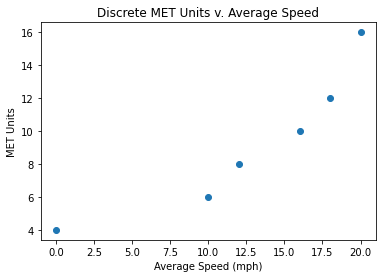

In [2]:
# -------------------- DISCRETE MET PLOT -------------------- #

cycling_speeds = list([0.0, 10.0, 12.0, 16.0, 18.0, 20.0])
met_units = list([4.0, 6.0, 8.0, 10.0, 12.0, 16.0])


plt.scatter(cycling_speeds, met_units)
plt.title("Discrete MET Units v. Average Speed")
plt.xlabel("Average Speed (mph)")
plt.ylabel("MET Units")
plt.savefig(path_figures / "DMET_v_AveSpeed.png")


This distribution represents experimentally known points of metabolic output for cycling. Note the seemingly exponential trend in MET units.

In [3]:
# -------------------- DISCRETE MET CALCULATION -------------------- #

def calc_pounds_to_kg(pounds):
    return pounds/2.205


def dmet_cycling_met_units(speed):
    """
    Calculates the MET units based on the provided average
    speed throughout the workout. Assumes speed is provided
    in miles per hour.
    """
    
    if speed <= 10.0:
        return 4
    elif speed <= 11.99:
        return 6
    elif speed <= 13.99:
        return 8
    elif speed <= 15.99:
        return 10
    elif speed <= 19.99:
        return 12
    else:
        return 14


def dmet_calories_per_minute(weight, speed):
    """
    Calculates the calories burned per minute according to 
    the workout parameters. Assumes weight is provided
    in kilograms and the speed is provided in miles per hour.
    """
    
    mets = dmet_cycling_met_units(speed)
    weight = calc_pounds_to_kg(weight)
    
    return 0.0175*mets*weight


def dmet_calc_total_calories_burned(weight, duration, speed):
    """
    Calculates the total caloric expenditure of a cycling
    workout based on the parameters provided. Assumes weight
    is provided in pounds, duration in minutes, speed in
    miles per hour.
    """
    
    calories_per_minute = dmet_calories_per_minute(weight, speed)
    
    return calories_per_minute*duration



In [4]:
# -------------------- EX. DISCRETE MET CALCULATION -------------------- #

dmet_calc_total_calories_burned(155.0, 300, 14.00)



3690.4761904761913

In [5]:
# -------------------- EX. DISCRETE MET CALCULATION -------------------- #

dmet_calc_total_calories_burned(155.0, 300, 15.99)



3690.4761904761913

Caloric expenditures for both 14.00 mph and 15.99 mph are equivalent which is thermodynamically impossible. Controlling for other factors, increased speed must always yield increased calories burned.



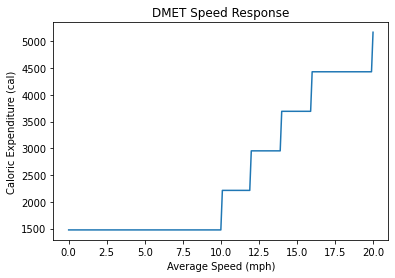

In [6]:
# -------------------- CALORIES v. SPEED USING DISCRETE MET -------------------- #

weight = 155.0
duration = 300

dmet_test_speeds = np.linspace(0, 20, 201)

dmet_calories_burned = list()
for speed in dmet_test_speeds:
    dmet_calories_burned.append(dmet_calc_total_calories_burned(weight, duration, speed))


plt.plot(dmet_test_speeds, dmet_calories_burned)
plt.title("DMET Speed Response")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Caloric Expenditure (cal)")
plt.savefig(path_figures / "DMET_Speed_Response.png")



The flat regions of the graph represent areas of impossibly equivalent metabolic outputs due to the zones of undefined DMET values. To elaborate, this means that increased cycling speed does not also result in increased calories burned, despite violating the law of conservation of energy. A realistic model of caloric expenditure would reflect a graph whose slope was always potitive and probably also always increasing. Afterall, increased speed must always require increased energy to be burned.

The sudden increases of metabolic output are equally ridiculous as the difference between 9.99 mph and 10.00 mph are over-dramatized due to the DMET inefficiencies.



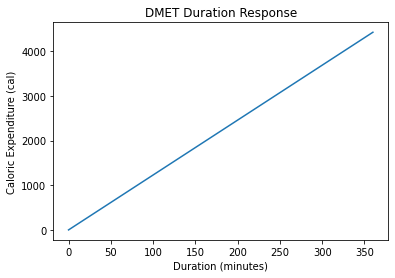

In [7]:
# -------------------- CALORIES v. DURATION USING DISCRETE MET -------------------- #

weight = 155.0
speed = 15.0

dmet_test_durations = np.linspace(0, 360, 361)

dmet_duration_calories_burned = list()
for duration in dmet_test_durations:
    dmet_duration_calories_burned.append(dmet_calc_total_calories_burned(weight, duration, speed))


plt.plot(dmet_test_durations, dmet_duration_calories_burned)
plt.title("DMET Duration Response")
plt.xlabel("Duration (minutes)")
plt.ylabel("Caloric Expenditure (cal)")
plt.savefig(path_figures / "DMET_v_Duration.png")



Note that the DMET relies on discrete speed values for cycling calculations but becomes continuous when the discrete dimension is held constant. The linear response of caloric consumption is rational as the calories burned per minute are held constant when speed and athlete weight are controlled. See the linear equation below:

$$
\begin{equation}
    \text{total calories} = \frac{\text{calories}}{\text{minute}} \cdot \text{duration}
\end{equation}
$$

This linear equation is consistent with my understanding of the application case.


## <a name="continuous-met"></a> [Continuous MET Calculation](#TOC)

Equiped with a background understanding of the DMET model, improvements can now safely be pursued. From the distribution of the known DMET points, it is clear that an exponential model is needed. This exponential trend is rational because the difference in subjective effort between bicycling at 1 mph and 4 mph is not equivalent to the difference between bicycling 20 mph and 23 mph. As the speed increases, dramatically more effort is required to realize an equivalent increase in speed.

Note that while caloric expenditure is exponential with respect to speed, the human potential is logarithmic. In other words, human beings asymptotically approach a theoretical maximum at which further progress is limited by the constraints of our corporial manifestations.



In [8]:
# -------------------- CONTINUOUS MET POLYNOMIAL -------------------- #

cmet_coefficients = np.polyfit(cycling_speeds, met_units, 3)
cmet_polynomial = np.poly1d(cmet_coefficients)



Note that a first-order polynomial is linear, which does not fit the apparent trend of the DMET scatter plot. Second-order polynomials are parabolic/quadratic but they resulted in a region where the MET units decrease with an increase in speed which is not biomechanically possible and was therefore thrown out. Third-order polynomials yield good results as fourth-order polynomials and beyond were overfit.



In [9]:
# -------------------- CMET SPEED RESPONSE -------------------- #

cmet_test_speeds = np.linspace(0, 20, 201)

cmet_met_units = list()
for speed in cmet_test_speeds:
    cmet_met_units.append(cmet_polynomial(speed))


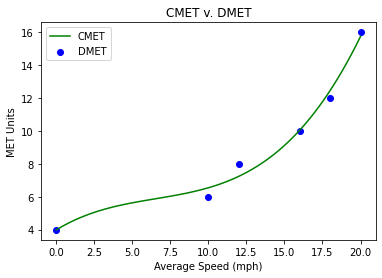

In [10]:
# -------------------- CMET/DMET MODEL OVERLAY -------------------- #

plt.scatter(cycling_speeds, met_units, label="DMET", color="blue")
plt.plot(cmet_test_speeds, cmet_met_units, label="CMET", color="green")

plt.legend(loc="upper left")
plt.title("CMET v. DMET")
plt.xlabel("Average Speed (mph)")
plt.ylabel("MET Units")
plt.savefig(path_figures / "CMET_v_DMET_Models.png")



When determining the order of the polynomial model, it is important to study the distribution of the original dataset. I can tell by the discrete distribution that the relationship between cycling speed and MET units is most likely quadtratic. Ergo, I tried a second-order polynomial $y = Ax^{2} + Bx + C$ but I noticed a region in a plot of the resulting model whereby the derivative was negative. In other words, for a region of the graph, bicycling faster cost less energy. Controlling for wind and terrain, this is an irrational behavior for the model so it was thrown out. This behavior disappeared when a third-order (cubic) polynomial $y = Ax^{3} + Bx^{2} + Cx + D$ was applied.

The cubic model is superior to the DMET but presents its own challenges with the clearly concave-convex regions of the graph, whose inflection point exists somewhere between 7.5 and 12.5 mph where $\ddot{y} = 0$. The inflection behavior suggests that the cyclist has optimal regions of velocity whereby the caloric consumption is lowered. Although this is probably true, the MET data does not try to support this assertion outright. Mathematically speaking inflection is guaranteed with a third degree polynomial because the second derivative is a linear equation, provided that the first coefficient is non-zero.

$$
\begin{aligned}
    y &= Ax^{3} + Bx^{2} + Cx + D \\
    \dot{y} &= 3Ax^2 + 2Bx + C \\
    \ddot{y} &= 6Ax + 2B
\end{aligned}
$$

Using a lower order polynomial (e.g. $y = Ax^{2} + Bx + C$ for $p_2$) would result in a constant second derivative ($\ddot{y} = 2A$) and therefore $\ddot{y} \neq 0$ provided that $A \neq 0$. For derivatives of polynomials $p_n \; \text{s.t.} n<2$ then $\ddot{y} = 0$ and therefore the inflection would not apply.

In [11]:
# -------------------- CONTINUOUS MET CALCULATION -------------------- #

def calc_pounds_to_kg(pounds):
    return pounds/2.205


def coefficients():
    return np.array([3.19343066e-03, -6.25952515e-02,
                     5.62785754e-01, 3.98022780e+00])


def cmet_cycling_met_units(speed):
    """
    Calculates the MET units based on the provided average
    speed throughout the workout. Uses a third-order MET
    polynomial. Assumes speed is provided in miles per hour.
    """

    polynomial = np.poly1d(coefficients())
    return polynomial(speed)


def cmet_calories_per_minute(weight, speed):
    """
    Calculates the calories burned per minute according to 
    the workout parameters. Uses a third-order MET polynomial.
    Assumes weight is provided in kilograms and the speed is
    provided in miles per hour.
    """
    
    mets = cmet_cycling_met_units(speed)
    weight = calc_pounds_to_kg(weight)
    
    return 0.0175*mets*weight


def cmet_calc_total_calories_burned(weight, duration, speed):
    """
    Calculates the total caloric expenditure of a cycling
    workout based on the parameters provided. Uses a third-
    order MET polynomial. Assumes weight is provided in
    pounds, duration in minutes, speed in miles per hour.
    """
    
    calories_per_minute = cmet_calories_per_minute(weight, speed)
    
    return calories_per_minute*duration



In [12]:
# -------------------- EX. CONTINUOUS MET CALCULATION -------------------- #

cmet_calc_total_calories_burned(155.0, 300, 14.00)



3082.77757838381

In [13]:
# -------------------- EX. CONTINUOUS MET CALCULATION -------------------- #

cmet_calc_total_calories_burned(155.0, 300, 15.99)



3701.7666874044457

Using the continuous MET calculation, no two speeds result in the same caloric output and small increases in speed result in proportional energy outputs as would be expected.

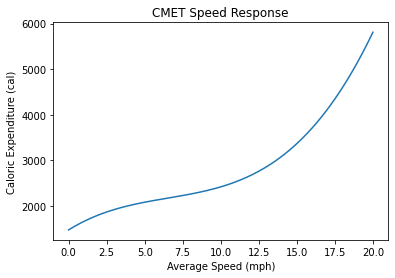

In [14]:
# -------------------- CALORIES v. SPEED USING CONTINUOUS MET -------------------- #

weight = 155.0
duration = 300

cmet_test_speeds = np.linspace(0, 20, 201)

cmet_calories_burned = list()
for speed in cmet_test_speeds:
    cmet_calories_burned.append(cmet_calc_total_calories_burned(weight, duration, speed))


plt.plot(cmet_test_speeds, cmet_calories_burned)
plt.title("CMET Speed Response")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Caloric Expenditure (cal)")
plt.savefig(path_figures / "CMET_Speed_Response.png")



Unsurprisingly, the speed response reflects the MET polynomial found earlier. The caloric output is simply the MET units after undergoing a series of scaling factors. Next, I will compare the continuous and discrete models to each other by similaring the 6 hour ride of a 155 pound cyclist with varying average speeds.



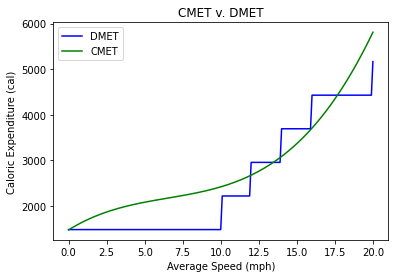

In [15]:
# -------------------- CMET/DMET COMPARISON -------------------- #

weight = 155.0
duration = 300

test_speeds = np.linspace(0, 20, 201)

dmet_calories_burned = list()
cmet_calories_burned = list()
dmet_cmet_error = list()
for speed in test_speeds:
    dmet_calories = dmet_calc_total_calories_burned(weight, duration, speed)
    cmet_calories = cmet_calc_total_calories_burned(weight, duration, speed)
    error = abs(dmet_calories - cmet_calories)
    
    dmet_calories_burned.append(dmet_calories)
    cmet_calories_burned.append(cmet_calories)
    dmet_cmet_error.append(error)
    

plt.plot(test_speeds, dmet_calories_burned, label="DMET", color="blue")
plt.plot(test_speeds, cmet_calories_burned, label="CMET", color="green")

plt.legend(loc="upper left")
plt.title("CMET v. DMET")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Caloric Expenditure (cal)")
plt.savefig(path_figures / "CMET_v_DMET_SpeedResponse.png")



Inflection points not withstanding, the continuous model offers a number of advantages over the discrete model. Most notably is the constant positive derivative in the speed response. Controlling for terrain and wind conditions, when a cyclist goes faster they must expend more energy for the system to be considered energetically conservative. This CMET model is valid under those constraints.

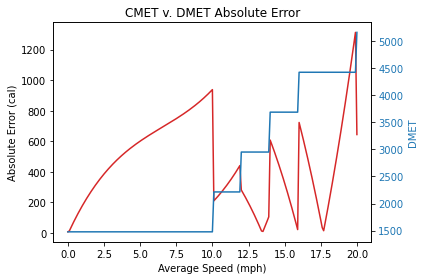

In [16]:

fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_title("CMET v. DMET Absolute Error")
ax1.set_xlabel("Average Speed (mph)")
ax1.set_ylabel("Absolute Error (cal)")
ax1.plot(test_speeds, dmet_cmet_error, color=color, label="Error")

ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel("DMET", color=color)
ax2.plot(test_speeds, dmet_calories_burned, color=color, label="DMET")
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.savefig(path_figures / "CMET_v_DMET_AbsoluteError.png")
plt.show()



These models differ the greatest when farther from the last point of defined MET value with several exceptions. This makes sense because it accounts for the discontinuities in the original DMET model. The exceptions occur when the error is minimized between 10 and 17.5 mph.



## <a name="power-based-met"></a> [Power Based MET Calculation](#TOC)

The MET units provide values for stationary bikes. On a stationary bike, the althete's performance cannot be measured in terms of speed but is instead measured as a function of power, commonly in the unit watts. Although this model is developed for the stationary bike, it controls for a number of factors such as wind and terrain by opting to measure the instantanious power applied by the athlete against the bike.

Ideally, power would be measured on a road bike and fed directly into this model and speed would be entirely ignored. Consequently, slower speeds uphill would reflect greater overall power and therefore greater caloric consumption, rather than lowered caloric consumption as suggested by the speed-based approach. Concordantly, headwinds and tailwinds would not calorically punish nor benefit the rider provided that applied power remained constant. In a speed-based model such scenarios would unjustly affect the estimated caloric consumption despite a constant applied power on behalf of the athlete, thereby violating the constraint of the conservation of energy with respect to the rider.



METs = 0.048 * power + 0.5
R-Squared: 0.994 with P-Value: 0.001



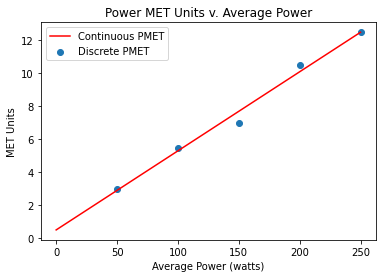

In [17]:
# -------------------- CONTINUOUS POWER MET DEVELOPMENT -------------------- #

power = list([50.0, 100, 150, 200, 250])
power_mets = list([3.0, 5.5, 7.0, 10.5, 12.5])

pmet_slope, pmet_intercept, r_value, p_value, std_err = stats.linregress(power, power_mets)
print(f"METs = {round(pmet_slope, 3)} * power + {round(pmet_intercept, 3)}")
print(f"R-Squared: {round(r_value, 3)} with P-Value: {round(p_value, 3)}\n")


test_powers = np.linspace(0, 250, 2501)

plt.scatter(power, power_mets, label="Discrete PMET")
plt.plot(test_powers, (pmet_slope * test_powers) + pmet_intercept, "r", label="Continuous PMET")
plt.legend(loc="upper left")
plt.title("Power MET Units v. Average Power")
plt.xlabel("Average Power (watts)")
plt.ylabel("MET Units")
plt.savefig(path_figures / "PMET_v_AveragePower.png")



Here the PMET distribution suggests a linear regression model be used. and the demonstrated linear model clearly fits the trend. More development is needed to see how power on a stationary bike related to power applied on the road. The R-Squared of 0.994 is outstanding and indicates that the variance of the PMET distribution is effectively described by the linear regression model.



## <a name="experimental-observations"></a> [Experimental Observations](#TOC)

Under Armor and similar sports technology companies have developed their own cycling ride-tracking systems. Included in the final ride report is an estimate of the caloric output. Within this section, the caloric outputs of these providers are explored. I am interested to see if the individual providers use different models to calculate caloric expenditure. Perhaps most importantly, I am interested in seeing if the distribution is exponential or linear with respect to the average speed.

MET units are not a recorded field in this case as the tracking software keeps MET values esoteric to the client. However, using the duration, distance, and estimated caloric output of each ride according to the tracker provider, the MET values were derived using the following formula:

$$
\begin{equation}
    \text{Estimated MET (EMET)} = \frac{\text{Calories}}{\text{Duration} \cdot 0.0175 \cdot \text{Weight}}
\end{equation}
$$

My own body weight has fluctuated throughout these rides, adding potential layer of complexity to this analysis. However, my weight we set to a constant value to make the analysis more straight forward.



In [18]:
# -------------------- LOAD CYCLING DATA -------------------- #

tracking_data = pd.read_csv(path_data / "CyclingTrackerData.csv")

Zeopoxa = tracking_data[tracking_data["Provider"] == "Zeopoxa"].reset_index(drop=True)
UnderArmour = tracking_data[tracking_data["Provider"] == "Under Armour"].reset_index(drop=True)
Garmin = tracking_data[tracking_data["Provider"] == "Garmin"].reset_index(drop=True)



### <a name="zeopoxa"></a> [Zeopoxa](#TOC)

Starting with the [Zeopoxa](https://www.zeopoxa.com/) tracker, a clearly linear distribution is presented. Using a simple linear regression, a statistical model of the MET calculation was created. Surprisingly, the model resulted in an R-Squared value of $1.00$ which means that $100\%$ of the variation in the data was accounted for in the regression model. Were the model more complex, I would regard such a high value with suspicion but given that the distribution is so clear and there are no clear outliers, the regression is clearly performing properly.

Despite the strong results from the linear model, it is important to note the sampling bias in the dataset as most rides have average speeds greater than $10 \; \text{mph}$. Ergo, the linear trend may not hold for extremely slow rides. Despite the bias, the sample with the lowest average speed still obeys the trend, suggesting that the linear model is truly appropriate for this dataset.

The linear distribution is interesting given that the METs cycling model suggests a logistic or exponential relationship between average speed and caloric output. The linear relationship is likely the result of a simpler model for calculating cycling speeds but without reverse engineering the application there is no way to be sure.



METs = 0.561 * average speed + 0.301
R-Squared: 1.0 with Standard Error: 0.001



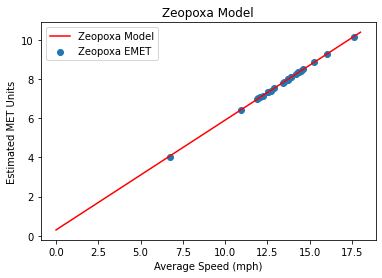

In [19]:
# -------------------- ZEOPOXA DISTRIBUTION -------------------- #

zeopoxa_average_speed = Zeopoxa["Average Speed"]
zeopoxa_estimated_met = Zeopoxa["Estimated MET Units"]

zeopoxa_slope, zeopoxa_intercept, r_value, p_value, std_err = stats.linregress(zeopoxa_average_speed, zeopoxa_estimated_met)
print(f"METs = {round(zeopoxa_slope, 3)} * average speed + {round(zeopoxa_intercept, 3)}")
print(f"R-Squared: {round(r_value, 3)} with Standard Error: {round(std_err, 3)}\n")


test_speeds = np.linspace(0, 18, 1801)

plt.scatter(zeopoxa_average_speed, zeopoxa_estimated_met, label="Zeopoxa EMET")
plt.plot(test_speeds, (zeopoxa_slope * test_speeds) + zeopoxa_intercept, "r", label="Zeopoxa Model")
plt.legend(loc="upper left")
plt.title("Zeopoxa Model")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Estimated MET Units")
plt.savefig(path_figures / "Zeopoxa_Model.png")



### <a name="under-armour"></a> [Under Armour](#TOC)

The Zeopoxa application has several GPS bugs that render the application less reliable. When I learned that Under Armour's MapMyRide app integrates with MyFitnessPal I decided to change tracking applications. The R-Squared value was similarly strong without any outliers to suggest a statistical error.

The sampling bias of faster rides still occurs although the slowest sample still strongly obeys the trend, suggesting an appropriate model selection has been made.

One obvious fault with this model is the negative y-intercept value. This model suggests, absurdly, that with an average speed of $\approx 3.96 \; \text{mph}$ the cyclist would burn no energy and that at any lesser speed the cyclist would actually gain energy. Both of these consequences of the model violate the laws of thermodynamics. A positive y-intercept can be explained by the basal metabolic rate, a person still burns energy at rest, but a negative y-intercept should never occur. Additionally, the slope of the model for Under Armour is inexplicably $73\%$ higher that the Zeopoxa model. Nevertheless the linear trend still holds and clearly Under Armour is using a linear model for their caloric calculations.



METs = 0.971 * average speed + -3.84
R-Squared: 0.999 with Standard Error: 0.013



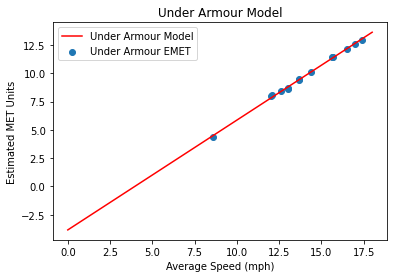

In [20]:
# -------------------- UNDER ARMOUR DISTRIBUTION -------------------- #

under_armour_average_speed = UnderArmour["Average Speed"]
under_armour_estimated_met = UnderArmour["Estimated MET Units"]

under_armour_slope, under_armour_intercept, r_value, p_value, std_err = stats.linregress(under_armour_average_speed, under_armour_estimated_met)
print(f"METs = {round(under_armour_slope, 3)} * average speed + {round(under_armour_intercept, 3)}")
print(f"R-Squared: {round(r_value, 3)} with Standard Error: {round(std_err, 3)}\n")


test_speeds = np.linspace(0, 18, 1801)

plt.scatter(under_armour_average_speed, under_armour_estimated_met, label="Under Armour EMET")
plt.plot(test_speeds, (under_armour_slope * test_speeds) + under_armour_intercept, "r", label="Under Armour Model")
plt.legend(loc="upper left")
plt.title("Under Armour Model")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Estimated MET Units")
plt.savefig(path_figures / "UnderArmour_Model.png")



### <a name="garmin"></a> [Garmin](#TOC)

The Garmin Forerunner 310XT makes its own estimates as to the number of calories burned per ride based on its own observations. However, small pauses during the workout are removed because the device can be easily paused and restarted at traffic lights and stop signs. For this reason, the average speed of a ride on the Garmin device is noticably and intentionally higher than the same ride tracked from the users phone. For this reason, the distribution suffered from a sampling bias whereby the average speed of each ride was higher than average though not dishonestly higher.

Although the Garmin tracking data suggests a linear trend, the distribution has a much larger variance than the previous datasets. This increased variance suggests that another factor must have been used to calculate the MET units for caloric output. I would assume that the average gradient of the ride is a logical second factor in determining how many calories the ride required.

Regardless of the larger variance, the linear regression model still explains approximately $91.7\%$ of the variance of the original dataset. This high R-Squared value still suggests that a vast majority of the dataset's variance comes from the average speed of the ride.



METs = 0.608 * average speed + 1.369
R-Squared: 0.917 with Standard Error: 0.046



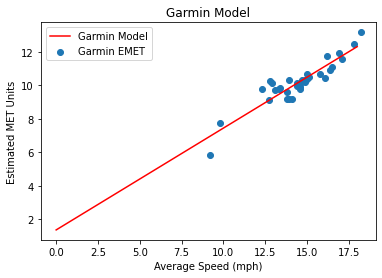

In [21]:
# -------------------- GARMIN DISTRIBUTION -------------------- #

garmin_average_speed = Garmin["Average Speed"]
garmin_estimated_met = Garmin["Estimated MET Units"]

garmin_slope, garmin_intercept, r_value, p_value, std_err = stats.linregress(garmin_average_speed, garmin_estimated_met)
print(f"METs = {round(garmin_slope, 3)} * average speed + {round(garmin_intercept, 3)}")
print(f"R-Squared: {round(r_value, 3)} with Standard Error: {round(std_err, 3)}\n")


test_speeds = np.linspace(0, 18, 1801)

plt.scatter(garmin_average_speed, garmin_estimated_met, label="Garmin EMET")
plt.plot(test_speeds, (garmin_slope * test_speeds) + garmin_intercept, "r", label="Garmin Model")
plt.legend(loc="upper left")
plt.title("Garmin Model")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Estimated MET Units")
plt.savefig(path_figures / "Garmin_Model.png")



### <a name="comparisons"></a> [Comparisons](#TOC)

Ultimately, all three tracking providers used a linear model despite the logistic model presented by the road cycling MET data. While Zeopoxa and Garmin had similar results in terms of the slope of the linear regression, the Garmin data had a much larger distribution. This distribution suggests that the average speed of the ride is the dominant though not the only factor in determining the caloric needs of the ride. The Under Armour model, while linear, had a much larger slope than the other two trackers and had a negative y-intercept, violating clear biochemical constraints. Despite these differences, the high R-Squared value of the Under Armour model confirms that $99.9\%$ of the variance in the dataset is explained by the linear regression. Such a large vote of confidence does not leave enough room for a second factor to be considered influential when calculating caloric consumption.



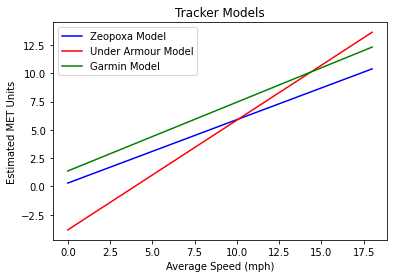

In [22]:
# -------------------- COMPARE DISTRIBUTIONS -------------------- #

test_speeds = np.linspace(0, 18, 1801)

plt.plot(test_speeds, (zeopoxa_slope * test_speeds) + zeopoxa_intercept, "b", label="Zeopoxa Model")
plt.plot(test_speeds, (under_armour_slope * test_speeds) + under_armour_intercept, "r", label="Under Armour Model")
plt.plot(test_speeds, (garmin_slope * test_speeds) + garmin_intercept, "g", label="Garmin Model")
plt.legend(loc="upper left")
plt.title("Tracker Models")
plt.xlabel("Average Speed (mph)")
plt.ylabel("Estimated MET Units")
plt.savefig(path_figures / "Tracker_Models.png")




## <a name="conclusions"></a> [Conclusions](#TOC)

Expanding the discrete model into the continuous domain improves the resulting predictions for caloric expenditure. Using a third-order polynomial model, the undefined regions of the discrete met values could be accounted for. Whereas the discrete model failed to scale with gradual increases in speed, the continous model ensures that increases in speed will always reflect increases in energy (calories) consumed.

Additionally, the power-based approach of a stationary-bike suggests a linear relationship between power output and calories consumed, offering a potentially superior model to caloric expenditure on the road once the relationship between power and road performance is better understood.

In order to determine how these models may be used in production, the cycling data from three major tracking applications/devices was evaluated. All three tracking providers used a linear model of caloric consumption. Of the three providers, two trackers used models whose coefficients were strongly related and one tracker used a model whose extrema violated essential biomechanical principals. Without a model to link the linear stationary-bike power output to the average speed of a road bike, the comparison between the power-based approach and the three road bike trackers could not be made.



*Written by Alice Seaborn September 25-29.*